# Setup

In [1]:
import os
import praw
from dotenv import load_dotenv
import json
from top2vec import Top2Vec
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sentence_transformers import SentenceTransformer
import os
import tensorflow as tf
import tensorflow_hub as hub



# Load variables from .env
load_dotenv()
client_id = os.getenv('REDDIT_CLIENT_ID')
client_secret = os.getenv('REDDIT_CLIENT_SECRET')
user_agent = os.getenv("REDDIT_USER_AGENT")


# Set up the Reddit instance
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
)

/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-01 12:03:14.053323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 12:03:15.025834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Topic modeling using posts as documents

## Load data

In [ ]:
# Define the subreddit you want to download from
subreddit = reddit.subreddit('ClashOfClans')

data = []

# Download posts
for submission in subreddit.search("flair:Discussion", sort='hot', limit=100):
    post_data = {
        "title": submission.title,
        "selftext": submission.selftext,
        "comments": []
    }
    
    # Download comments from the current post
    submission.comments.replace_more(limit=None)  # Fetch more comments if needed
    for comment in submission.comments.list():
        post_data["comments"].append(comment.body)
    
    data.append(post_data)

# Convert to JSON
json_data = json.dumps(data, indent=4)
documents = []
for post in data:
    combined_text =  post['selftext'] + ' ' + ' '.join(post['comments'])
    documents.append(combined_text)

## Processing functions

In [77]:
# Downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initializations
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words_to_remove = ['supercell', 'coc']
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuations and special characters
    text = re.sub(r'\W', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove the specified words
    removal_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b'
    text = re.sub(removal_pattern, '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join tokens back to string
    text = ' '.join(tokens)
    return text

# Test
sample_text = "This is a sample sentence, containing URLs https://www.example.com and numbers 12345."
print(preprocess(sample_text))


sample sentence containing url number


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ilarivp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ilarivp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilarivp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [217]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
def print_topics(model):
    topic_words, word_scores, topic_nums = model.get_topics()

    for idx, topic in enumerate(topic_nums):
        print(f"Topic {idx + 1}")
        print("-------------------")
        for word, score in zip(topic_words[idx], word_scores[idx]):
            print(word, "(Score:", score,")")
        print("\n")


def preprocess_new(text):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    import string
    
    # Tokenize, remove punctuation, lowercase, remove stopwords
    tokens = word_tokenize(text)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

def compute_coherence_for_top2vec(model):
    # Preprocess documents
    texts = [preprocess_new(doc) for doc in model.documents]

    # Create a Gensim dictionary from the preprocessed documents
    dictionary = Dictionary(texts)

    # Get topic words
    topic_words, word_scores, topic_scores = model.get_topics(len(topic_nums))

    # Compute coherence for each topic
    coherences = []
    for words in topic_words:
        cm = CoherenceModel(topics=[words], texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(cm.get_coherence())

    return coherences

def compute_coherence_for_topics_no_model(documents, word_scores_per_new_topic):
    # Preprocess documents
    texts = [preprocess_new(doc) for doc in documents]

    # Create a Gensim dictionary from the preprocessed documents
    dictionary = Dictionary(texts)

    topic_words = []
    for key in word_scores_per_new_topic.keys():
        topic_words.append(list(word_scores_per_new_topic[key].keys()))
    # Compute coherence for each topic
    coherences = []
    for words in topic_words:
        cm = CoherenceModel(topics=[words], texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(cm.get_coherence())

    return coherences    



def compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents):
    """
    Compute the silhouette score for a given Top2Vec model.

    Parameters:
    - model: The trained Top2Vec model
    - model_to_use: The embedding model identifier for SentenceTransformer
    - preprocessed_documents: A list of preprocessed documents for embedding encoding

    Returns:
    - Silhouette score if there are multiple labels, or a message indicating there's only one label
    """

    # Retrieve document topics
    document_topics = model.get_documents_topics([i for i in range(len(model.documents))])[0]
    document_embeddings = model.document_vectors

    # Convert topic scores to labels for silhouette scoring
    labels = document_topics

    # Calculate and return the silhouette score or a relevant message
    if len(set(labels)) > 1:
        silhouette = silhouette_score(document_embeddings, labels)
        return silhouette
    else:
        return "Cannot compute silhouette score for a single label"

def compute_silhouette_score_for_no_model(model, document_topics):
    """
    Compute the silhouette score for a given Top2Vec model.

    Parameters:
    - model: The trained Top2Vec model
    - model_to_use: The embedding model identifier for SentenceTransformer
    - preprocessed_documents: A list of preprocessed documents for embedding encoding

    Returns:
    - Silhouette score if there are multiple labels, or a message indicating there's only one label
    """

    # Retrieve document topics
    document_embeddings = model.document_vectors

    # Convert topic scores to labels for silhouette scoring
    labels = document_topics

    # Calculate and return the silhouette score or a relevant message
    if len(set(labels)) > 1:
        silhouette = silhouette_score(document_embeddings, labels)
        return silhouette
    else:
        return "Cannot compute silhouette score for a single label"

def get_embeddings(texts, model, batch_size=32):
    """Get embeddings for a list of texts, processing in batches."""
    embeddings = []
    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = model(batch_texts)
        embeddings.append(batch_embeddings)
    # Concatenate all batch embeddings together
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings


## Topic modeling

In [58]:

preprocessed_documents = [preprocess(doc) for doc in documents]
preprocessed_documents = [doc for doc in preprocessed_documents if doc.strip()]

umap_args = {
    'n_neighbors': 15,  # You can play around with this number.
    'n_components': 5,
    'metric': 'cosine'
}


hdbscan_args = {
    'min_cluster_size': 10,  # Adjust this as needed
    'min_samples': 5,       # Adjust this as needed
    'metric': 'euclidean',  # or 'cosine', etc.
    'cluster_selection_method': 'eom'  # or 'leaf'
}

umap_args = {'n_neighbors': 20,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42}
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'l1',
                'cluster_selection_method': 'leaf'}

model_to_use = 'distiluse-base-multilingual-cased'
model_to_use = 'universal-sentence-encoder-large'

model = Top2Vec(
    preprocessed_documents,
    min_count = 10,
    embedding_model=model_to_use,
    workers=4,
    umap_args=umap_args,
    hdbscan_args=hdbscan_args,
    embedding_batch_size = 12
)

# model = Top2Vec(documents, embedding_model='distiluse-base-multilingual-cased', workers=4)
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)
coherences = compute_coherence_for_top2vec(model)
for idx, coherence in enumerate(coherences):
    print(f"Topic {idx}, Coherence Score: {coherence.round(4)}")

average_coherence = sum(coherences) / len(coherences)
print(f"Average Coherence Score: {average_coherence.round(4)}")


# Usage example:
result = compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents)
print(f"Silhouette Score: {str(result.round(4))}")

2023-10-01 16:48:33,655 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-10-01 16:48:33,848 - top2vec - INFO - Downloading universal-sentence-encoder-large model
INFO:top2vec:Downloading universal-sentence-encoder-large model
2023-10-01 16:48:48,714 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-10-01 16:49:07,464 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use 

[189 125 109  85  76  60  46  43  39  38  37  35  30  30  30  29  28  27
  26  26  25  25  24  22  21  20  20  18  17  17  17  16  15  15  15  14
  14  14  13  13  12  12  12  12  12  11  11  10]
Topic 0, Coherence Score: 0.3102
Topic 1, Coherence Score: 0.5469
Topic 2, Coherence Score: 0.3422
Topic 3, Coherence Score: 0.3692
Topic 4, Coherence Score: 0.3197
Topic 5, Coherence Score: 0.4727
Topic 6, Coherence Score: 0.3924
Topic 7, Coherence Score: 0.5062
Topic 8, Coherence Score: 0.3218
Topic 9, Coherence Score: 0.3713
Topic 10, Coherence Score: 0.3929
Topic 11, Coherence Score: 0.5312
Topic 12, Coherence Score: 0.4747
Topic 13, Coherence Score: 0.3728
Topic 14, Coherence Score: 0.3873
Topic 15, Coherence Score: 0.4002
Topic 16, Coherence Score: 0.3243
Topic 17, Coherence Score: 0.3578
Topic 18, Coherence Score: 0.4562
Topic 19, Coherence Score: 0.5812
Topic 20, Coherence Score: 0.3839
Topic 21, Coherence Score: 0.3204
Topic 22, Coherence Score: 0.4013
Topic 23, Coherence Score: 0.400

## Analyze topics

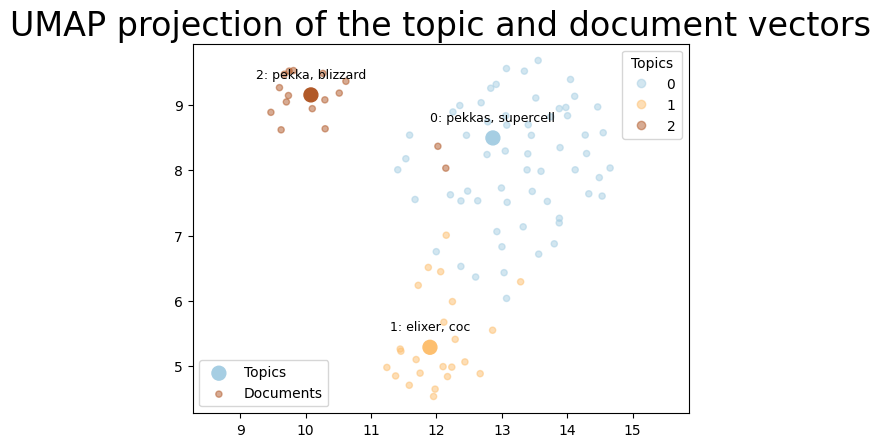

In [27]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# 1. Get topic vectors, their weights, and the top words for each topic
topic_weights, topic_nums = model.get_topic_sizes()
topic_vectors = model.topic_vectors
topic_words, word_scores, _ = model.get_topics()

# Create a set to keep track of already used words
used_words = set()

# Function to get two unique top words for each topic
def get_top_words(words):
    top_words = []
    for word in words:
        if word not in used_words:
            top_words.append(word)
            used_words.add(word)
        if len(top_words) == 2:
            break
    return ', '.join(top_words)

# Get two top words for each topic
top_words = [get_top_words(words) for words in topic_words]

# 2. Get document vectors and document topics
document_vectors = model.document_vectors
document_topics = model.doc_top  # Use model.doc_top to get the topic assignments

# Create a unique color for each topic number
unique_topics = np.unique(document_topics)
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_topics)))  # Use the 'Paired' colormap
colormap = ListedColormap(colors)

# 5. Plot the embeddings

# Prepare the colors for topic points based on the unique topic numbers
topic_colors = colormap(unique_topics / max(unique_topics))

# Plotting topic vectors with their weights
plt.scatter(topic_embedding[:, 0], topic_embedding[:, 1], s=100, c=topic_colors, alpha=1, label='Topics')

# Plotting document vectors colored by topic (adjust size and alpha to your preference)
sc = plt.scatter(document_embedding[:, 0], document_embedding[:, 1], s=20, alpha=0.5, c=document_topics, cmap=colormap, label='Documents')

# Create a legend for document colors
legend1 = plt.legend(*sc.legend_elements(), title="Topics")
plt.gca().add_artist(legend1)

# Annotate each topic number along with the top words from the topic
for i, num in enumerate(topic_nums):
    annotation = f"{num}: {top_words[i]}"
    plt.annotate(
        annotation, 
        (topic_embedding[i, 0], topic_embedding[i, 1]), 
        fontsize=9, 
        ha='center', 
        va='bottom',  # align the bottom of the text
        xytext=(0, 10),  # shift text 10 points upward
        textcoords='offset points'
    )


# Adjusting the plot visuals
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the topic and document vectors', fontsize=24)
plt.legend()
plt.show()

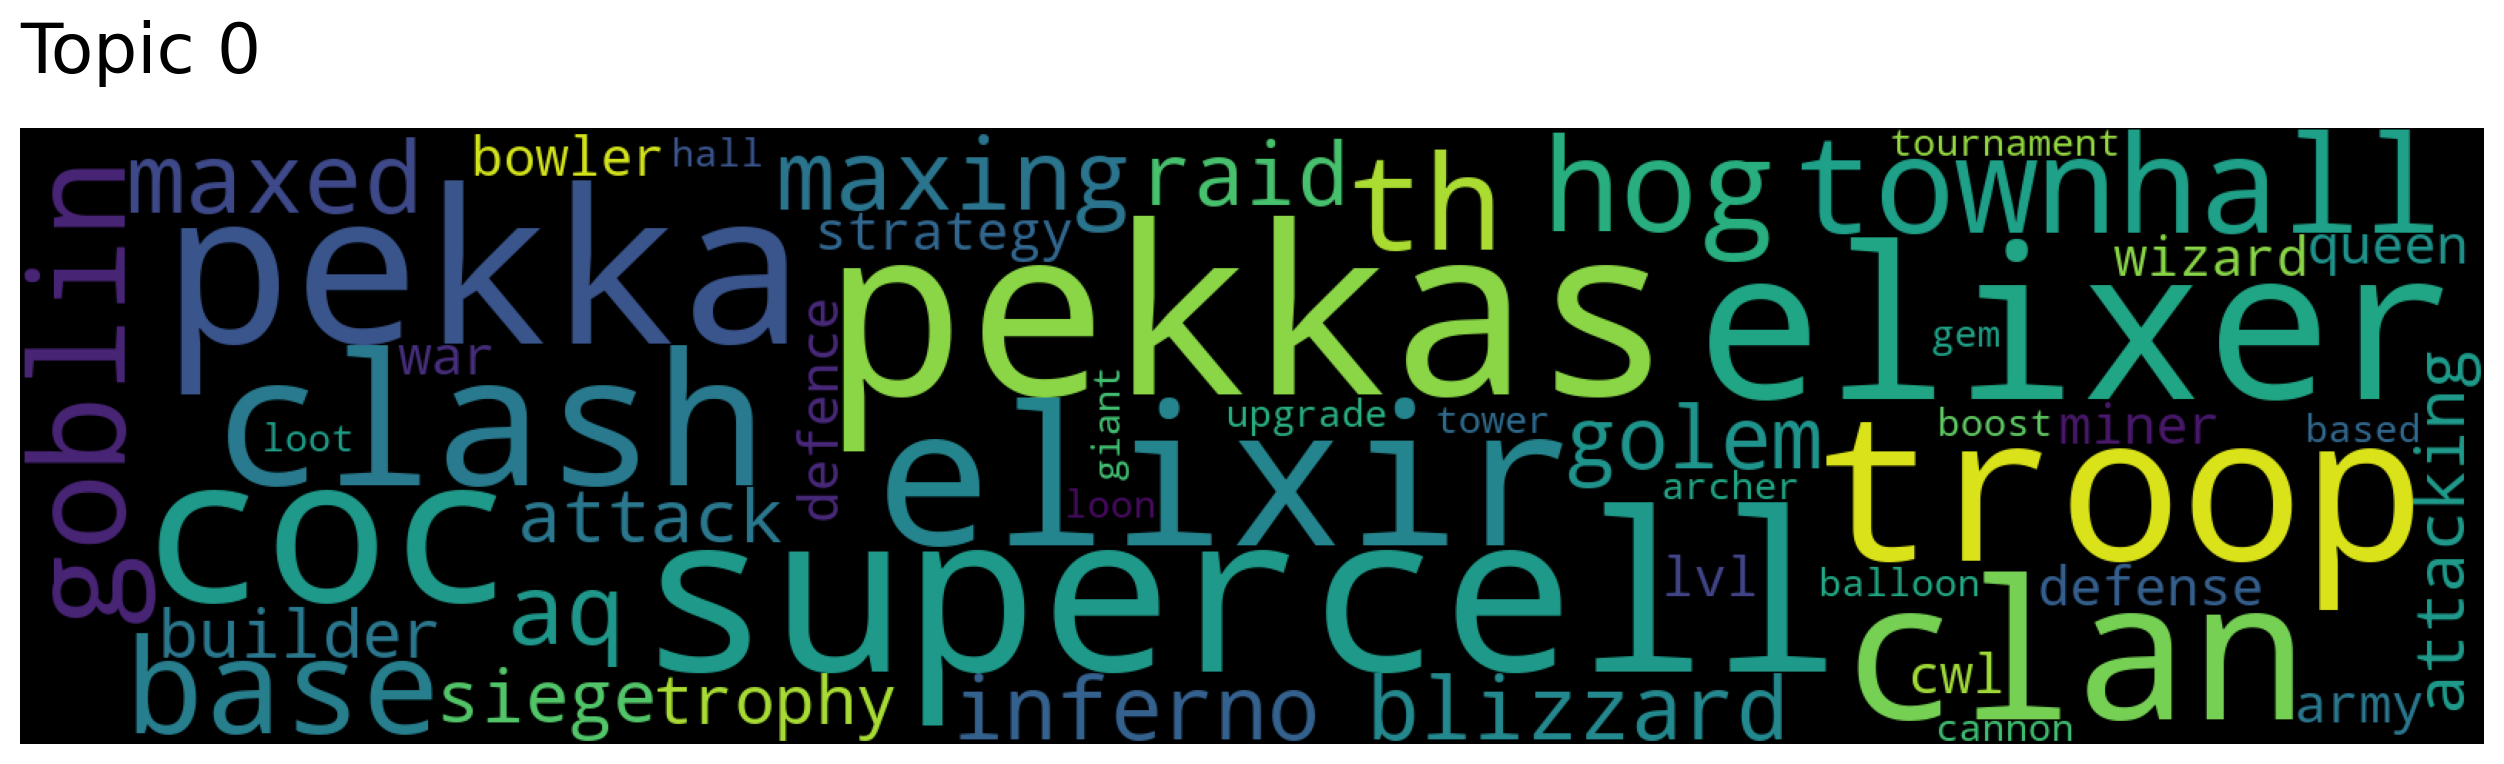

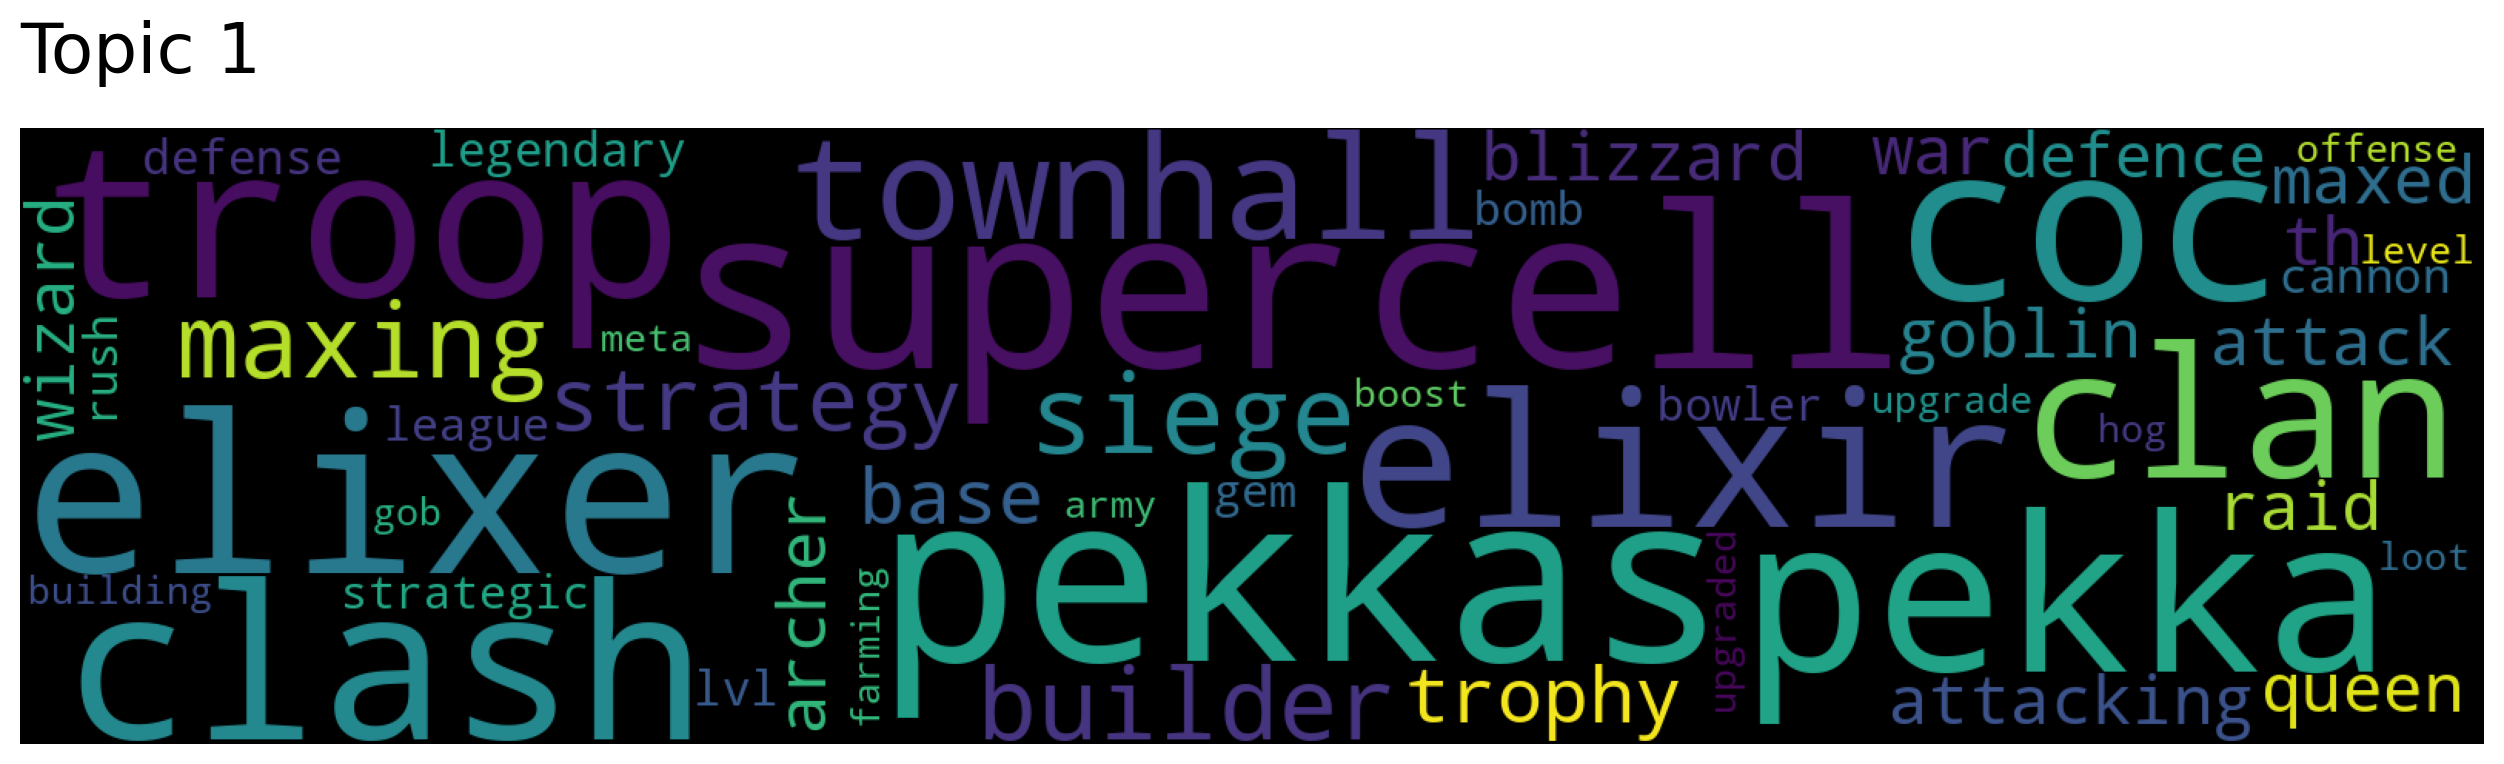

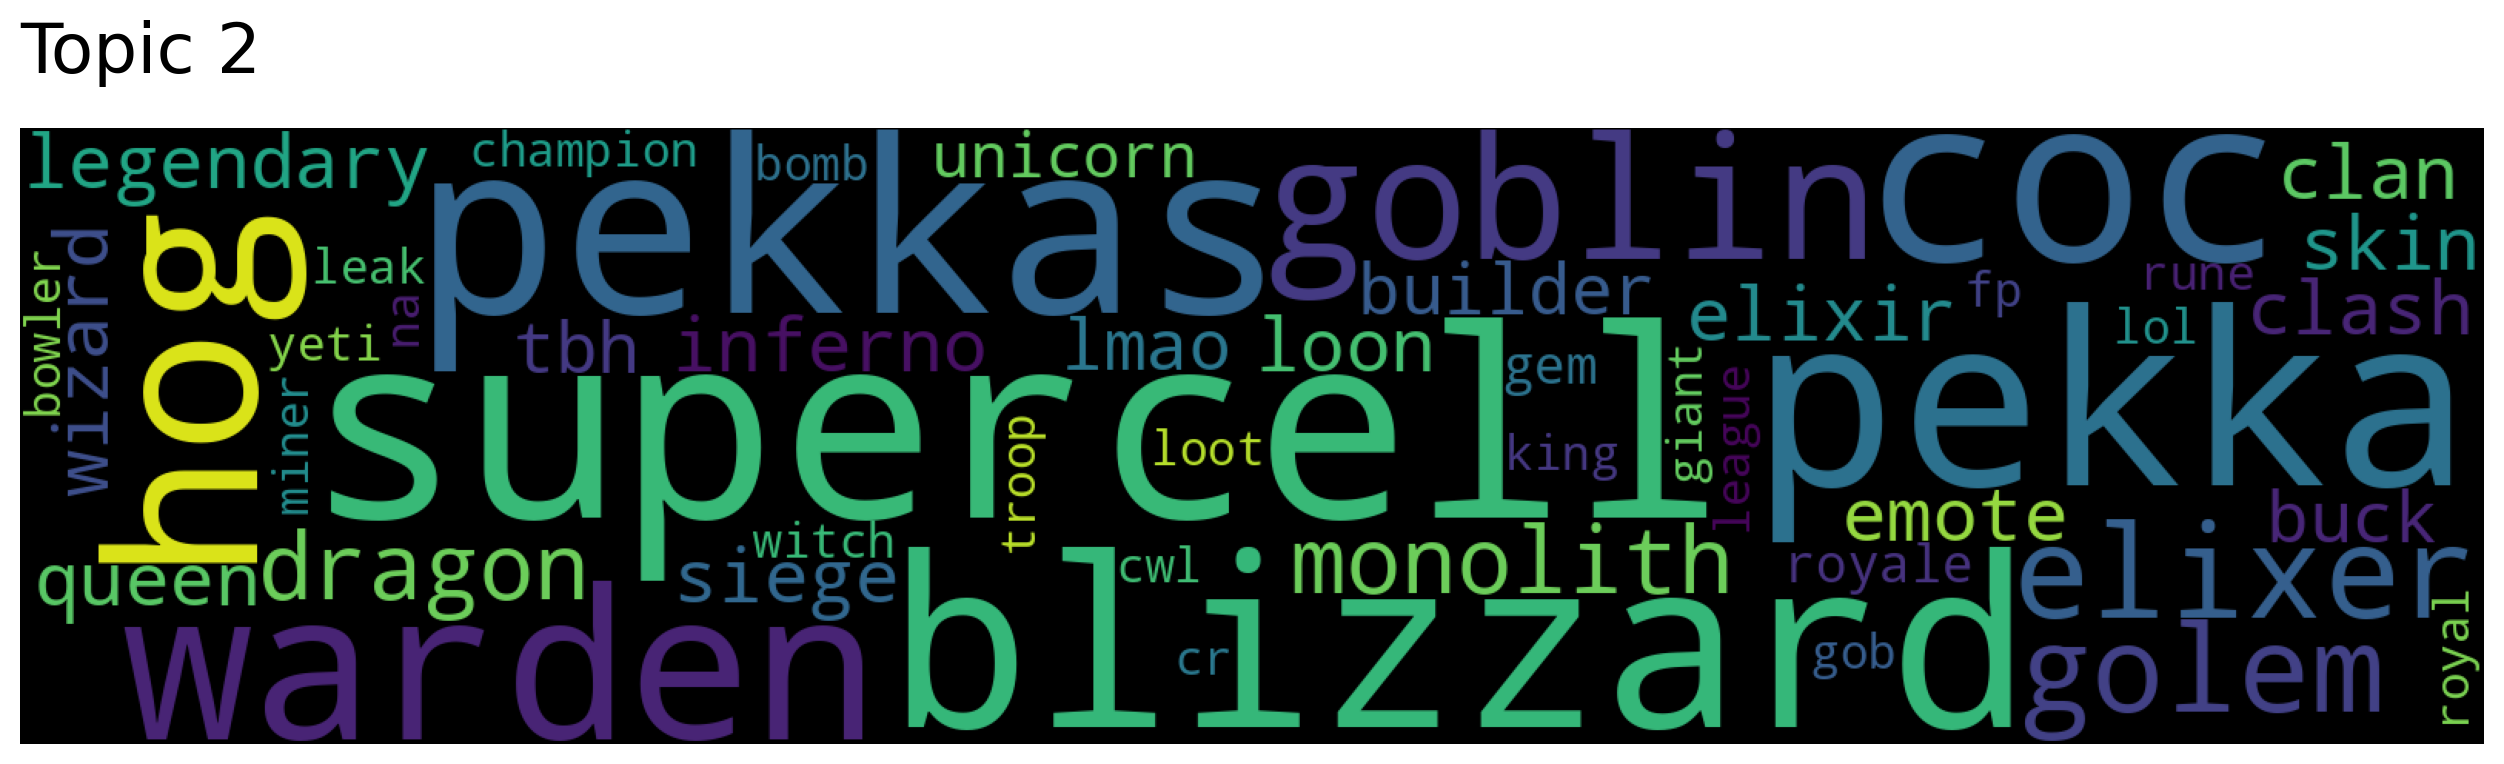

In [28]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

# Topic modeling using comment chains as documents

## Load comment chains

In [123]:
from datetime import datetime


def get_comment_chain(comment):
    chain_text = comment.body
    chain_timestamps = [datetime.utcfromtimestamp(comment.created_utc)]
    for reply in comment.replies:
        reply_text, reply_timestamps = get_comment_chain(reply)
        chain_text += '\n' + reply_text
        chain_timestamps.extend(reply_timestamps)
    return chain_text, chain_timestamps

data = []

# Download posts
for submission in subreddit.search("flair:Discussion", sort='hot', limit=500):
    post_data = {
        "title": submission.title,
        "selftext": submission.selftext,
        "timestamp": datetime.utcfromtimestamp(submission.created_utc),
        "comment_chains": []
    }

    # Download comments from the current post
    submission.comments.replace_more(limit=None)  # Fetch more comments if needed
    for comment in submission.comments:
        comment_chain_text, comment_chain_timestamps = get_comment_chain(comment)
        comment_chain_data = {
            "text": comment_chain_text,
            "timestamps": comment_chain_timestamps
        }
        post_data["comment_chains"].append(comment_chain_data)

    data.append(post_data)

# Save the collected data to a JSON file
with open('reddit_data_comment_chain.json', 'w') as f:
    json.dump(data, f, indent=4, default=str)  # Add default=str to handle datetime objects

In [124]:
# Load the collected data from the JSON file
with open('reddit_data_comment_chain.json', 'r') as f:
    data = json.load(f)

documents = []
timestamps = []  # List to store the timestamp of the first comment in each comment chain

# Process the data into documents for topic modeling
for post in data:
    for comment_chain in post['comment_chains']:
        combined_text = post['title'] + ' ' + post['selftext'] + ' ' + comment_chain['text']
        # Each comment chain is treated as a separate document
        documents.append(combined_text)
        # Capture the timestamp of the first comment in the comment chain
        if comment_chain['timestamps']:  # Check if the timestamps list is not empty
            timestamps.append(comment_chain['timestamps'][0])

# Now 'documents' is ready for topic modeling and 'timestamps' contains the relevant timestamps


## Topic modeling for comment chains

In [245]:

preprocessed_documents = [preprocess(doc) for doc in documents]
preprocessed_documents = [doc for doc in preprocessed_documents if doc.strip()]

umap_args = {
    'n_neighbors': 30,  # You can play around with this number.
    'n_components': 10,
    'metric': 'cosine'
}


hdbscan_args = {
    'min_cluster_size': 50,  # Adjust this as needed
    'min_samples': 10,       # Adjust this as needed
    'metric': 'euclidean',  # or 'cosine', etc.
    'cluster_selection_method': 'eom'  # or 'leaf'
}

model_to_use = 'distiluse-base-multilingual-cased'
model_to_use = 'universal-sentence-encoder-large'

model = Top2Vec(
    preprocessed_documents,
    min_count = 60,
    embedding_model=model_to_use,
    workers=4,
    umap_args=umap_args,
    hdbscan_args=hdbscan_args,
    embedding_batch_size = 36
)

# model = Top2Vec(documents, embedding_model='distiluse-base-multilingual-cased', workers=4)
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

2023-10-01 22:49:17,499 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-10-01 22:49:18,531 - top2vec - INFO - Downloading universal-sentence-encoder-large model
INFO:top2vec:Downloading universal-sentence-encoder-large model
2023-10-01 22:50:30,694 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-10-01 22:52:09,234 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-10-01 22:52:29,864 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-10-01 22:52:30,113 - top2vec - INFO - Finding topics
INFO:

[670 282 274 208 199 196 187 175 166 156 156 152 149 142 137 122 112  97
  95  93  88  86  84  75  71  68]


## Analyze topics

In [246]:
# Calculate metrics for topics
coherences = compute_coherence_for_top2vec(model)
for idx, coherence in enumerate(coherences):
    print(f"Topic {idx}, Coherence Score: {coherence.round(4)}")
average_coherence = sum(coherences) / len(coherences)
print(f"Average Coherence Score: {average_coherence.round(4)}")
silhouette = compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents)
print(f"Silhouette Score: {str(silhouette.round(4))}")

Topic 0, Coherence Score: 0.3209
Topic 1, Coherence Score: 0.3557
Topic 2, Coherence Score: 0.3009
Topic 3, Coherence Score: 0.3123
Topic 4, Coherence Score: 0.3591
Topic 5, Coherence Score: 0.2505
Topic 6, Coherence Score: 0.3037
Topic 7, Coherence Score: 0.3191
Topic 8, Coherence Score: 0.4249
Topic 9, Coherence Score: 0.3145
Topic 10, Coherence Score: 0.3415
Topic 11, Coherence Score: 0.3128
Topic 12, Coherence Score: 0.2402
Topic 13, Coherence Score: 0.3608
Topic 14, Coherence Score: 0.288
Topic 15, Coherence Score: 0.3532
Topic 16, Coherence Score: 0.306
Topic 17, Coherence Score: 0.406
Topic 18, Coherence Score: 0.3316
Topic 19, Coherence Score: 0.3753
Topic 20, Coherence Score: 0.3858
Topic 21, Coherence Score: 0.3315
Topic 22, Coherence Score: 0.3726
Topic 23, Coherence Score: 0.4076
Topic 24, Coherence Score: 0.2509
Topic 25, Coherence Score: 0.3562
Average Coherence Score: 0.3339
Silhouette Score: 0.164


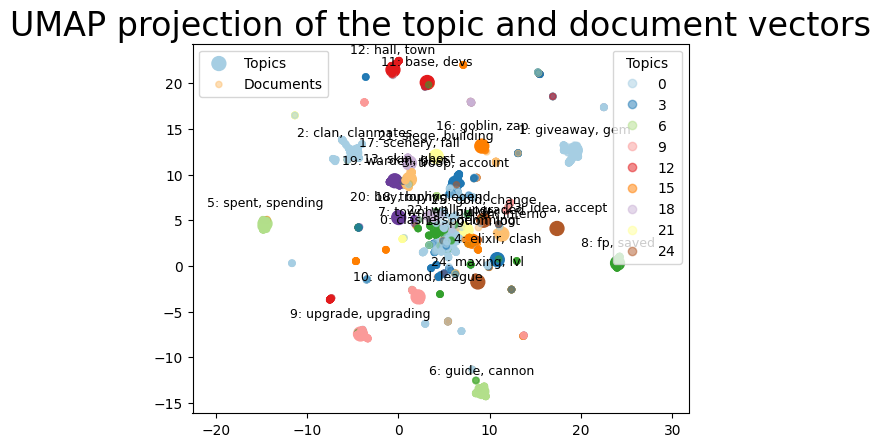

In [247]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


# Function to get two unique top words for each topic
def get_top_words(words):
    # Create a set to keep track of already used words
    top_words = []
    for word in words:
        if word not in used_words:
            top_words.append(word)
            used_words.add(word)
        if len(top_words) == 2:
            break
    return ', '.join(top_words)

# 1. Get topic vectors, their weights, and the top words for each topic
topic_weights, topic_nums = model.get_topic_sizes()
topic_vectors = model.topic_vectors
topic_words, word_scores, _ = model.get_topics()


used_words = set()

# Get two top words for each topic
top_words = [get_top_words(words) for words in topic_words]

# 2. Get document vectors and document topics
document_vectors = model.document_vectors
document_topics = model.doc_top  # Use model.doc_top to get the topic assignments

# Create a unique color for each topic number
unique_topics = np.unique(document_topics)
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_topics)))  # Use the 'Paired' colormap
colormap = ListedColormap(colors)

# 3. Combine topic vectors and document vectors for UMAP transformation
all_vectors = np.vstack([topic_vectors, document_vectors])

# 4. Reduce dimensions using UMAP on the combined set of vectors
reducer = umap.UMAP(init='random')
embedding = reducer.fit_transform(all_vectors)

# Split the embeddings back into topics and documents
topic_embedding = embedding[:len(topic_vectors)]
document_embedding = embedding[len(topic_vectors):]

# 5. Plot the embeddings

# Prepare the colors for topic points based on the unique topic numbers
topic_colors = colormap(unique_topics / max(unique_topics))

# Plotting topic vectors with their weights
plt.scatter(topic_embedding[:, 0], topic_embedding[:, 1], s=100, c=topic_colors, alpha=1, label='Topics')

# Plotting document vectors colored by topic (adjust size and alpha to your preference)
sc = plt.scatter(document_embedding[:, 0], document_embedding[:, 1], s=20, alpha=0.5, c=document_topics, cmap=colormap, label='Documents')

# Create a legend for document colors
legend1 = plt.legend(*sc.legend_elements(), title="Topics")
plt.gca().add_artist(legend1)

# Annotate each topic number along with the top words from the topic
for i, num in enumerate(topic_nums):
    annotation = f"{num}: {top_words[i]}"
    plt.annotate(
        annotation, 
        (topic_embedding[i, 0], topic_embedding[i, 1]), 
        fontsize=9, 
        ha='center', 
        va='bottom',  # align the bottom of the text
        xytext=(0, 10),  # shift text 10 points upward
        textcoords='offset points'
    )


# Adjusting the plot visuals
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the topic and document vectors', fontsize=24)
plt.legend()
plt.show()

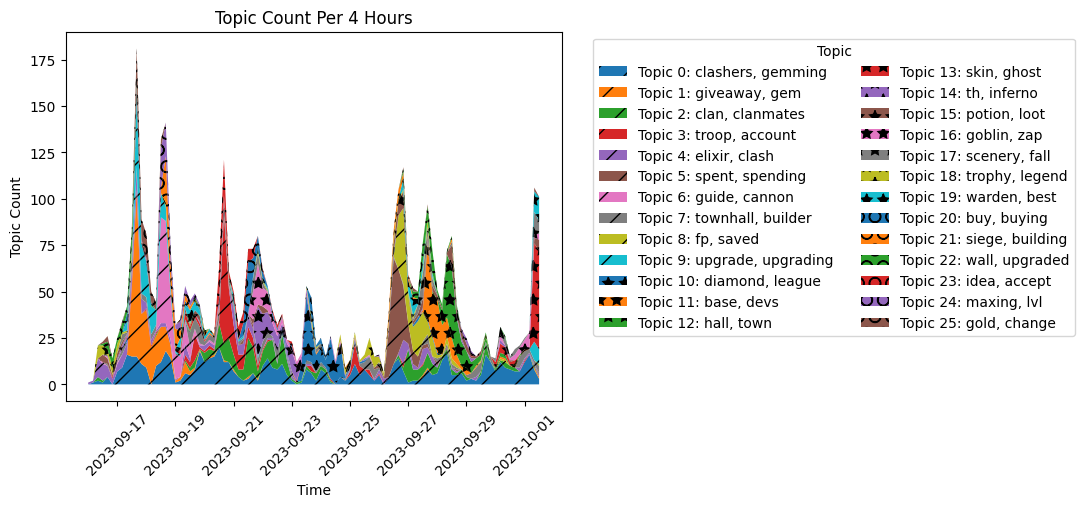

In [248]:
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assume topics is a list of topics corresponding to each document
# Assume timestamps is a list of timestamps corresponding to each document

# Step 2: Aggregate Data
data_dict = defaultdict(lambda: defaultdict(int))  # Nested dictionary to hold counts


for topic, timestamp in zip(model.doc_top, timestamps):
    timestamp_dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    data_dict[timestamp_dt][topic] += 1  # Use the datetime object as the key

# Convert the nested dictionary to a pandas DataFrame
data_df = pd.DataFrame(data_dict).T.fillna(0)
data_df.index = pd.to_datetime(data_df.index)  # Convert the index to datetime objects
data_df.sort_index(inplace=True)  # Sort the DataFrame by the index

# Resample and aggregate the data over 4-hour intervals
data_df = data_df.resample('4H').sum()

# Sort the columns (topics) alphabetically before plotting
data_df = data_df.sort_index(axis=1)
topic_words, word_scores, _ = model.get_topics()

# Get two top words for each topic
used_words = set()
top_words = [get_top_words(words) for words in topic_words]
new_col_names = [
    f'Topic {topic_num}: {topic_word}'
    for topic_num, topic_word in enumerate(top_words)
]

data_df.columns = new_col_names


# # Step 3: Plotting
# data_df.plot.area()
# plt.xlabel('Time')
# plt.ylabel('Topic Count')
# plt.title('Topic Count Per 4 Hours')

# # Move legend to upper right outside the plot area and sort topics alphabetically
# plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

# Get cumulative sum for stacking
data_cum = data_df.cumsum(axis=1)

fig, ax = plt.subplots()

# Define hatch patterns
hatches_patterns = ['/', '*', 'O', '+', '\\', 'x', 'o', '|', '-', '.']

# Ensure there are enough hatches by repeating the pattern
hatches = hatches_patterns * ((len(data_df.columns) // len(hatches_patterns)) + 1)

# Plot each area separately with its own hatch pattern
for i, col in enumerate(data_df.columns):
    hatch_group = i // 10  # Determine which group of 10 the current topic falls into
    hatch_index = hatch_group % len(hatches_patterns)  # Get the index of the hatch pattern to use
    hatch = hatches_patterns[hatch_index]  # Get the hatch pattern
    if i == 0:
        ax.fill_between(data_df.index, 0, data_cum[col], hatch=hatch, label=col)
    else:
        ax.fill_between(data_df.index, data_cum.iloc[:, i - 1], data_cum[col], hatch=hatch, label=col)

plt.xlabel('Time')
plt.ylabel('Topic Count')
plt.title('Topic Count Per 4 Hours')

# Move legend to upper right outside the plot area and sort topics alphabetically
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=(len(data_df.columns) + 14) // 15)
# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()

# DOES NOT WORK NEEDS TO BE REVISITED!

## Aggregate all topics into 20 

In [140]:
# there are too many topics, let's aggregate

from sklearn.metrics import pairwise_distances
import numpy as np
from collections import defaultdict
from scipy.cluster.hierarchy import linkage, fcluster

topic_vectors = model.topic_vectors

# It's common to use cosine similarity for topic vectors, but we need to convert that to distance
distance_matrix = pairwise_distances(topic_vectors, metric='cosine')
# Perform hierarchical clustering
Z = linkage(distance_matrix, method='average')  # 'average' linkage method can be replaced with 'ward' or others
# Form clusters
n_clusters = 20
clusters = fcluster(Z, n_clusters, criterion='maxclust')

# Initialize a dictionary to hold the aggregated topics
aggregated_topics = defaultdict(list)

# Aggregate topics within each cluster
for cluster_id, topic_vector in zip(clusters, topic_vectors):
    aggregated_topics[cluster_id].append(topic_vector)

# Create new topic vectors by averaging the topic vectors within each cluster
new_topic_vectors = np.array([np.mean(np.array(vectors), axis=0) for vectors in aggregated_topics.values()])
# Assuming clusters is the array obtained from hierarchical clustering
old_to_new_topic_mapping = {old_topic_idx: new_cluster_id for old_topic_idx, new_cluster_id in enumerate(clusters)}

# Assuming doc_top is the array of original topic assignments for each document
new_doc_topics = np.array([old_to_new_topic_mapping[old_topic] for old_topic in model.doc_top])

# Create a new document-topic matrix
# The following is a simplified example and assumes binary assignment (a document belongs to a single topic)
# In practice, you may have a probability distribution over topics for each document

num_docs = len(new_doc_topics)
new_doc_topic_matrix = np.zeros((num_docs, n_clusters))  # Assuming n_clusters is the number of new topics

for doc_idx, new_topic in enumerate(new_doc_topics):
    new_doc_topic_matrix[doc_idx, new_topic - 1] = 1


/tmp/ipykernel_560/2884114625.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='average')  # 'average' linkage method can be replaced with 'ward' or others


### Calculate metrics

In [219]:
# Let's calculate coherence and silhouette:
# Calculate metrics for topics
coherences = compute_coherence_for_topics_no_model(preprocessed_documents, word_scores_per_new_topic)
coherences = dict(zip(list(word_scores_per_new_topic.keys()), coherences))
coherences = {k: coherences[k] for k in sorted(coherences.keys())}
for idx, coherence in coherences.items():
    print(f"Topic {idx}, Coherence Score: {coherence.round(4)}")
average_coherence = sum(coherences.values()) / len(coherences)
print(f"Average Coherence Score: {average_coherence.round(4)}")
silhouette = compute_silhouette_score_for_no_model(model, new_doc_topics)
print(f"Silhouette Score: {str(silhouette.round(4))}")

Topic 1, Coherence Score: 0.373
Topic 2, Coherence Score: 0.3858
Topic 3, Coherence Score: 0.2505
Topic 4, Coherence Score: 0.4118
Topic 5, Coherence Score: 0.4693
Topic 6, Coherence Score: 0.4221
Topic 7, Coherence Score: 0.3637
Topic 8, Coherence Score: 0.2718
Topic 9, Coherence Score: 0.2619
Topic 10, Coherence Score: 0.3032
Topic 11, Coherence Score: 0.345
Topic 12, Coherence Score: 0.3701
Topic 13, Coherence Score: 0.3342
Topic 14, Coherence Score: 0.3355
Topic 15, Coherence Score: 0.3016
Topic 16, Coherence Score: 0.2758
Topic 17, Coherence Score: 0.4076
Topic 18, Coherence Score: 0.4624
Topic 19, Coherence Score: 0.4249
Topic 20, Coherence Score: 0.3833
Average Coherence Score: 0.3577
Silhouette Score: 0.1255


### Plot timeline

#### Calculate top2 words

In [170]:
from sklearn.metrics.pairwise import cosine_similarity

old_topic_words = model.topic_words
old_topic_word_vectors = model.word_vectors
# word scores are cosine similarity 

# Dictionary to hold the word scores for each new topic
word_scores_per_new_topic = defaultdict(dict)

# Iterate through each old topic, its words, and word vectors
for old_topic_idx, words in enumerate(old_topic_words):
    # Map the old topic to the new topic
    new_topic_idx = old_to_new_topic_mapping[old_topic_idx]
    # Get the vector for the new topic
    new_topic_vector = new_topic_vectors[new_topic_idx-1]
    
    # Iterate through each word and its vector
    for word, word_vector in zip(words, old_topic_word_vectors):
        # Calculate the cosine similarity between the word vector and the new topic vector
        similarity = cosine_similarity([new_topic_vector], [word_vector])[0][0]
        # Store the similarity score
        word_scores_per_new_topic[new_topic_idx][word] = similarity
# Dictionary to hold the top 2 words for each new topic
top_2_words_per_new_topic = {}

# Iterate through each new topic and its word scores
for new_topic_idx, word_scores in word_scores_per_new_topic.items():
    # Sort the word scores in descending order and select the top 2
    sorted_word_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:2]
    top_2_words_per_new_topic[new_topic_idx] = sorted_word_scores


[('gemming', 0.15763475), ('potion', 0.15763475)]
[('effort', 0.2663619), ('big', 0.23411556)]
[('hall', 0.13633695), ('bomb', 0.13633695)]
[('bought', 0.34516504), ('healing', 0.21106526)]
[('increase', 0.16260539), ('zap', 0.16260539)]
[('upgrade', 0.13379532), ('worst', 0.13379532)]
[('mind', 0.18701322), ('raid', 0.18701322)]
[('probably', 0.110238545), ('maxed', 0.09364483)]
[('second', 0.31211177), ('gem', 0.31211177)]
[('diamond', 0.19583708), ('drag', 0.19583708)]
[('spot', 0.20198041), ('higher', 0.20198041)]
[('trap', 0.20883098), ('blimp', 0.17003895)]
[('able', 0.19818935), ('game', 0.18664372)]
[('buy', 0.18005359), ('play', 0.18005359)]
[('poll', 0.3894583), ('cc', 0.17614444)]
[('hog', 0.3145389), ('gem', 0.12306368)]
[('die', 0.11618617), ('defeated', 0.0898024)]
[('fortitude', 0.084731154), ('upgrading', 0.084731154)]
[('bad', 0.13531622), ('extra', 0.13345343)]
[('clan', 0.13006258), ('star', 0.06120208)]


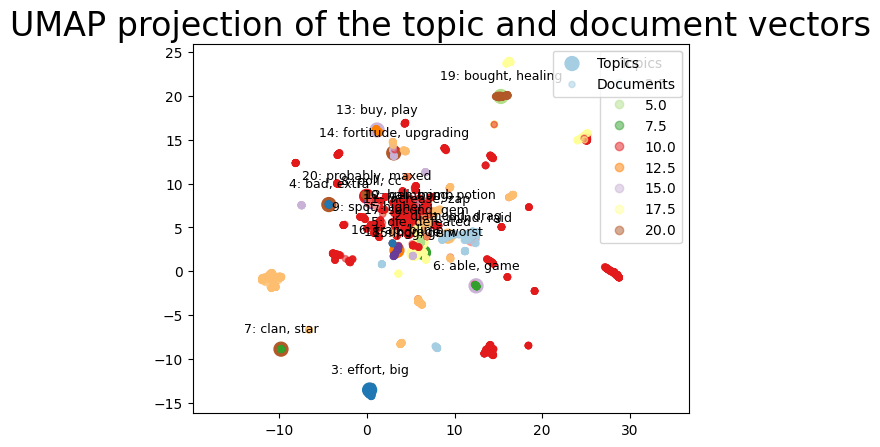

In [240]:
# 2. Get document vectors and document topics
topic_vectors = new_topic_vectors
document_vectors = model.document_vectors
document_topics = new_doc_topics  # Use model.doc_top to get the topic assignments

# Create a unique color for each topic number
unique_topics = np.unique(document_topics)
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_topics)))  # Use the 'Paired' colormap
colormap = ListedColormap(colors)

# 3. Combine topic vectors and document vectors for UMAP transformation
all_vectors = np.vstack([topic_vectors, document_vectors])

# 4. Reduce dimensions using UMAP on the combined set of vectors
reducer = umap.UMAP(init='random')
embedding = reducer.fit_transform(all_vectors)

# Split the embeddings back into topics and documents
topic_embedding = embedding[:len(topic_vectors)]
document_embedding = embedding[len(topic_vectors):]

# 5. Plot the embeddings

# Prepare the colors for topic points based on the unique topic numbers
topic_colors = colormap(unique_topics / max(unique_topics))

# Plotting topic vectors with their weights
plt.scatter(topic_embedding[:, 0], topic_embedding[:, 1], s=100, c=topic_colors, alpha=1, label='Topics')

# Plotting document vectors colored by topic (adjust size and alpha to your preference)
sc = plt.scatter(document_embedding[:, 0], document_embedding[:, 1], s=20, alpha=0.5, c=document_topics, cmap=colormap, label='Documents')

# Create a legend for document colors
legend1 = plt.legend(*sc.legend_elements(), title="Topics")
plt.gca().add_artist(legend1)

# Annotate each topic number along with the top words from the topic
topic_keys = list(top_2_words_per_new_topic.keys())
for i, num in enumerate(topic_keys):
    words = top_2_words_per_new_topic[num]
    annotation = f"{num}: {words[0][0]}, {words[1][0]}"
    plt.annotate(
        annotation, 
        (topic_embedding[i, 0], topic_embedding[i, 1]), 
        fontsize=9, 
        ha='center', 
        va='bottom',  # align the bottom of the text
        xytext=(0, 10),  # shift text 10 points upward
        textcoords='offset points'
    )


# Adjusting the plot visuals
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the topic and document vectors', fontsize=24)
plt.legend()
plt.show()

#### Plot the actual groups

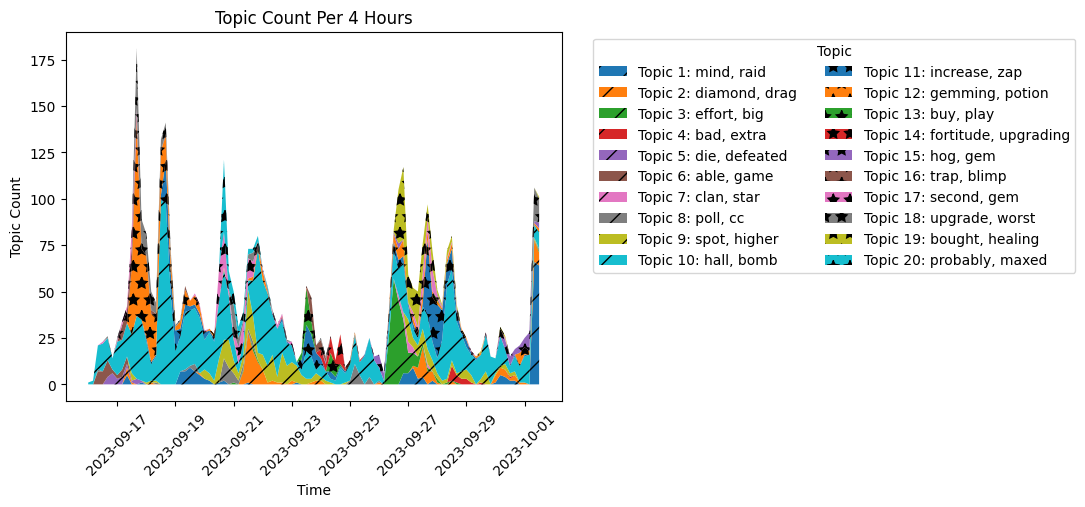

In [179]:
# Step 2: Aggregate Data
data_dict = defaultdict(lambda: defaultdict(int))  # Nested dictionary to hold counts


for new_topic, timestamp in zip(new_doc_topics, timestamps):
    timestamp_dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    data_dict[timestamp_dt][new_topic] += 1  # Use the datetime object as the key

# Convert the nested dictionary to a pandas DataFrame
data_df = pd.DataFrame(data_dict).T.fillna(0)
data_df.index = pd.to_datetime(data_df.index)  # Convert the index to datetime objects
data_df.sort_index(inplace=True)  # Sort the DataFrame by the index

# Resample and aggregate the data over 4-hour intervals
data_df = data_df.resample('4H').sum()
# Sort the columns (topics) alphabetically before plotting
data_df = data_df.sort_index(axis=1)

# Create a dictionary for renaming the columns
rename_dict = {
    topic_num: f'Topic {topic_num}: {words[0][0]}, {words[1][0]}'
    for topic_num, words in top_2_words_per_new_topic.items()
}

# Rename the columns of data_df using the rename_dict
data_df.rename(columns=rename_dict, inplace=True)



# Get cumulative sum for stacking
data_cum = data_df.cumsum(axis=1)

fig, ax = plt.subplots()

# Define hatch patterns
hatches_patterns = ['/', '*', 'O', '+', '\\', 'x', 'o', '|', '-', '.']

# Ensure there are enough hatches by repeating the pattern
hatches = hatches_patterns * ((len(data_df.columns) // len(hatches_patterns)) + 1)

# Plot each area separately with its own hatch pattern
for i, col in enumerate(data_df.columns):
    hatch_group = i // 10  # Determine which group of 10 the current topic falls into
    hatch_index = hatch_group % len(hatches_patterns)  # Get the index of the hatch pattern to use
    hatch = hatches_patterns[hatch_index]  # Get the hatch pattern
    if i == 0:
        ax.fill_between(data_df.index, 0, data_cum[col], hatch=hatch, label=col)
    else:
        ax.fill_between(data_df.index, data_cum.iloc[:, i - 1], data_cum[col], hatch=hatch, label=col)

plt.xlabel('Time')
plt.ylabel('Topic Count')
plt.title('Topic Count Per 4 Hours')

# Move legend to upper right outside the plot area and sort topics alphabetically
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=(len(data_df.columns) + 14) // 15)
# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()

### Generate wordclouds

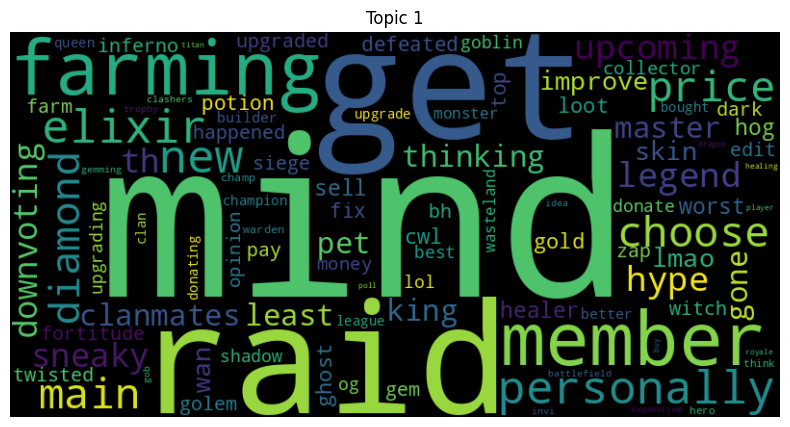

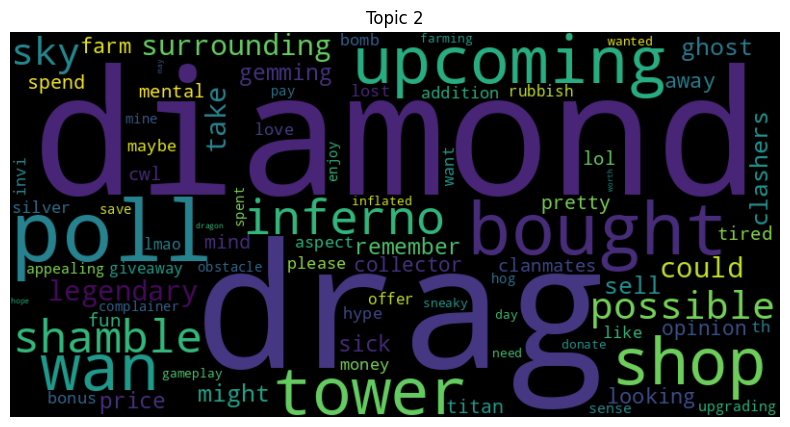

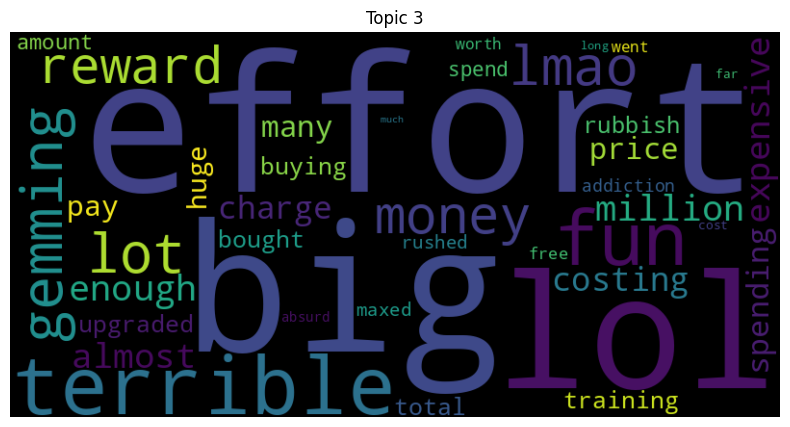

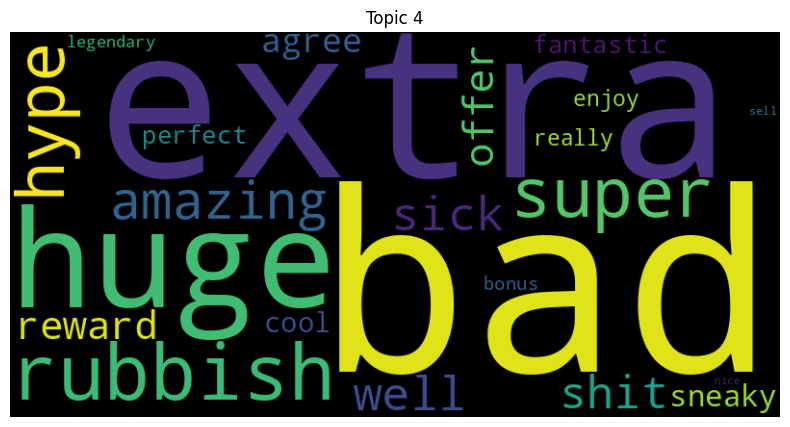

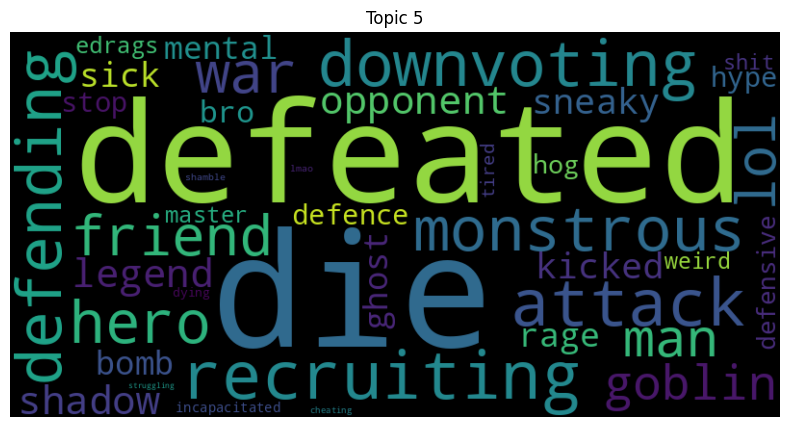

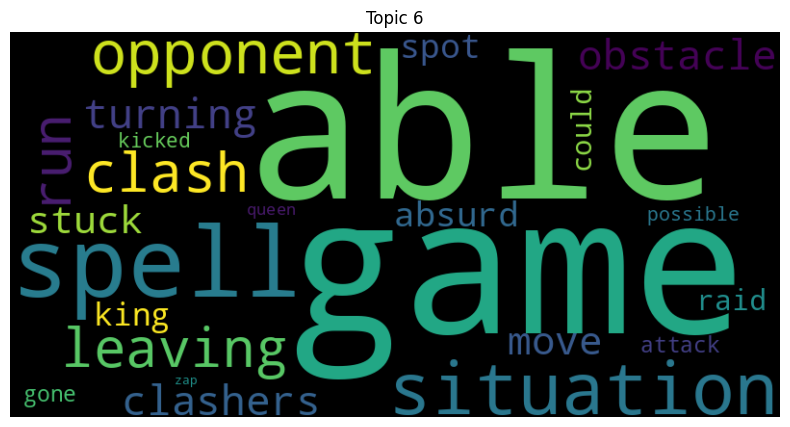

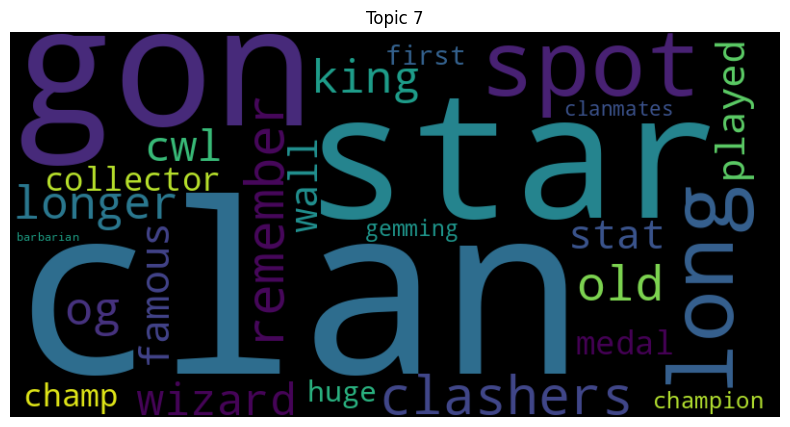

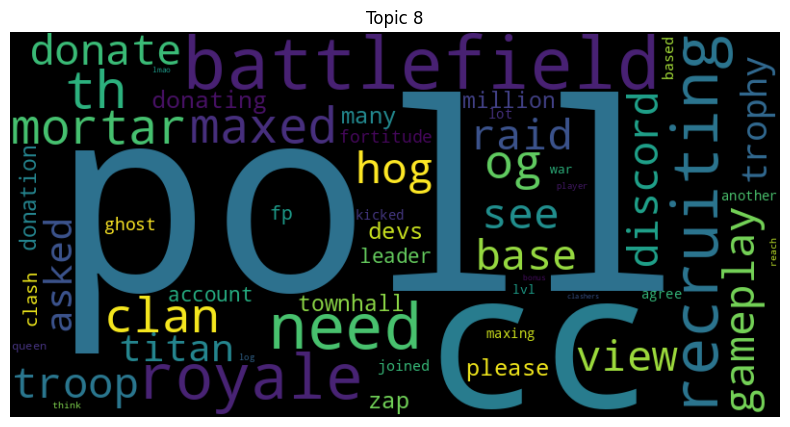

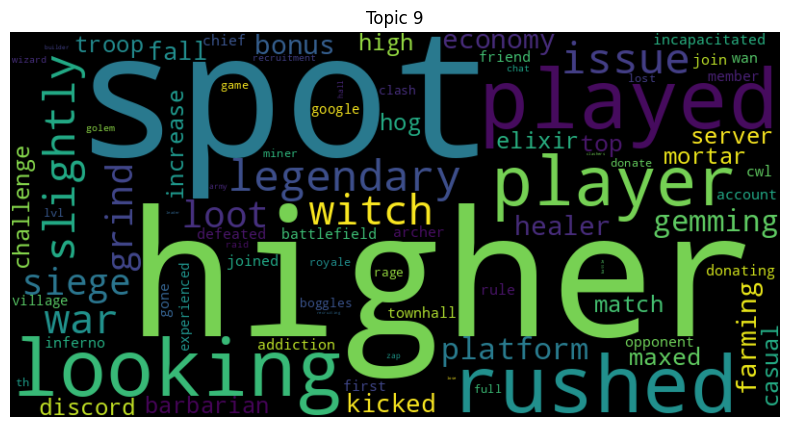

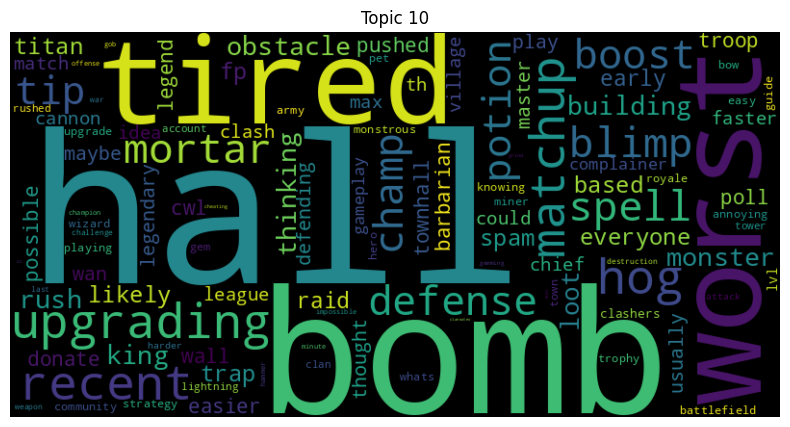

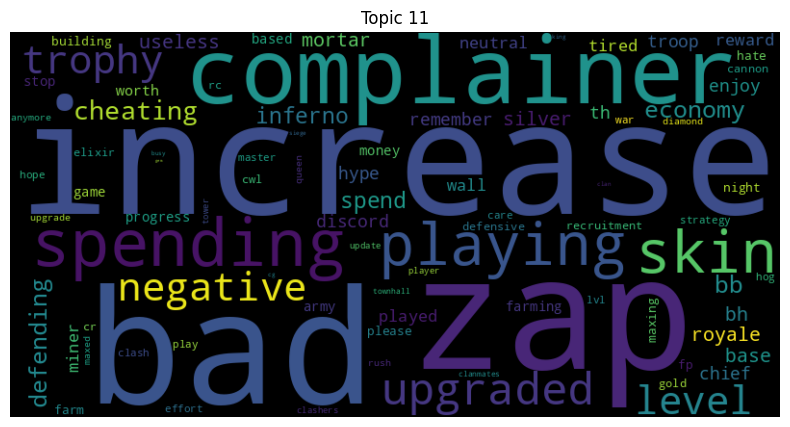

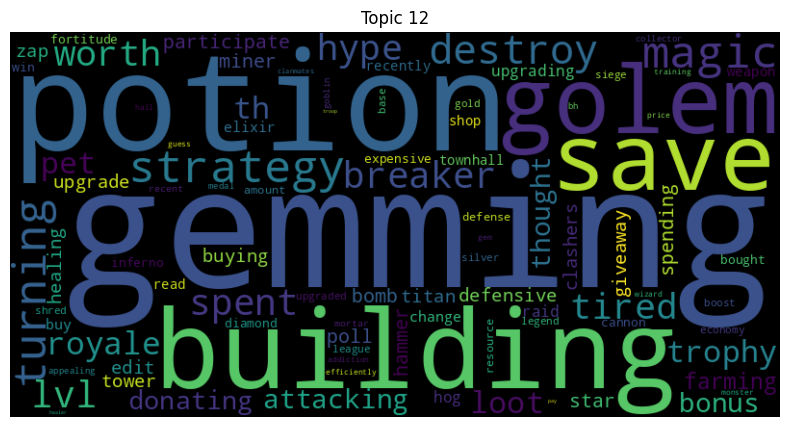

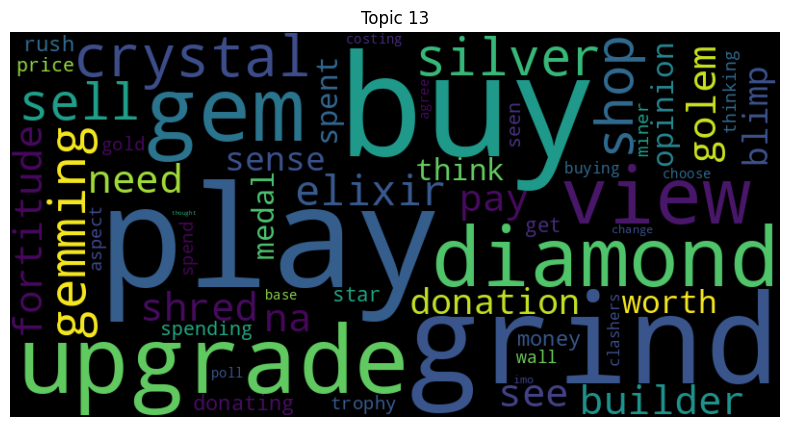

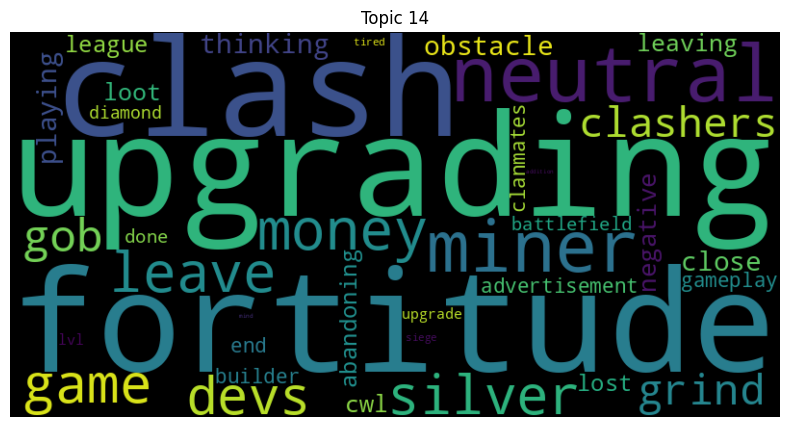

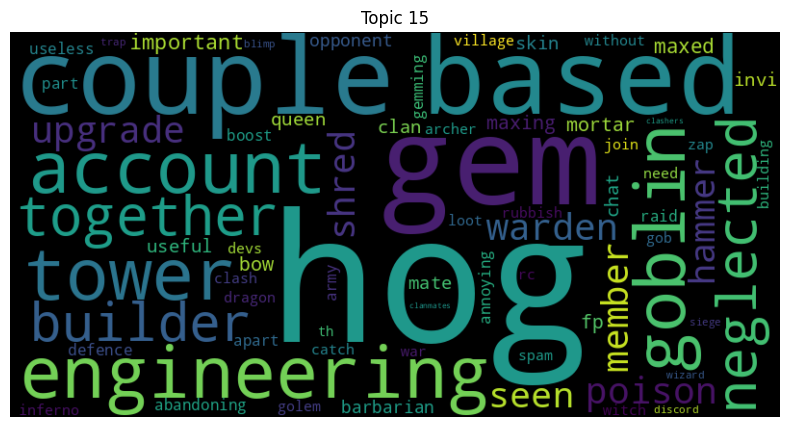

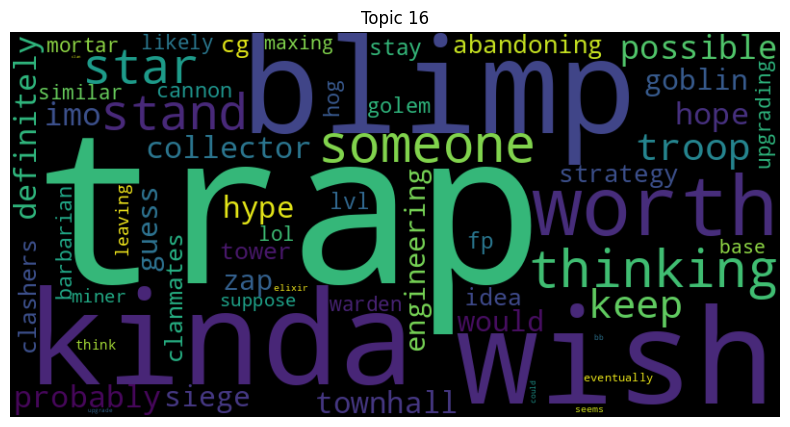

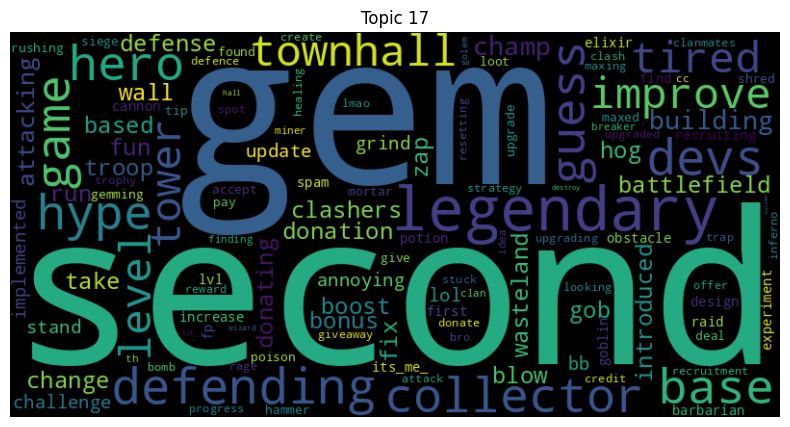

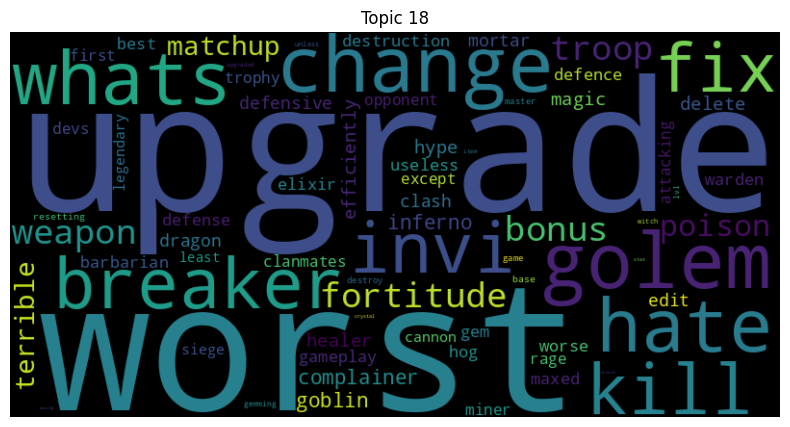

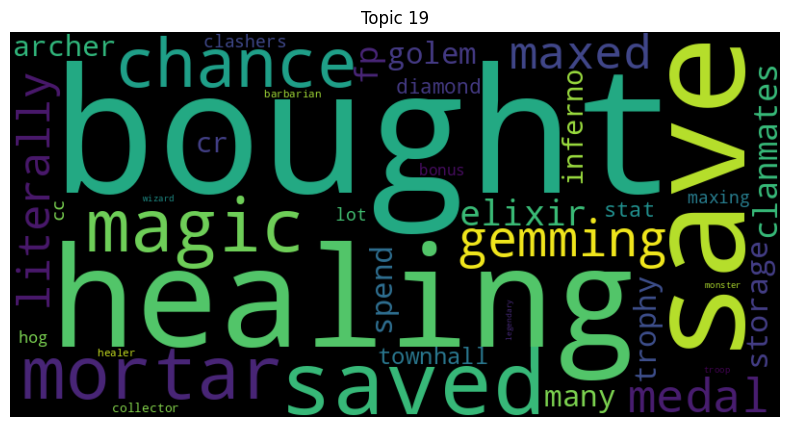

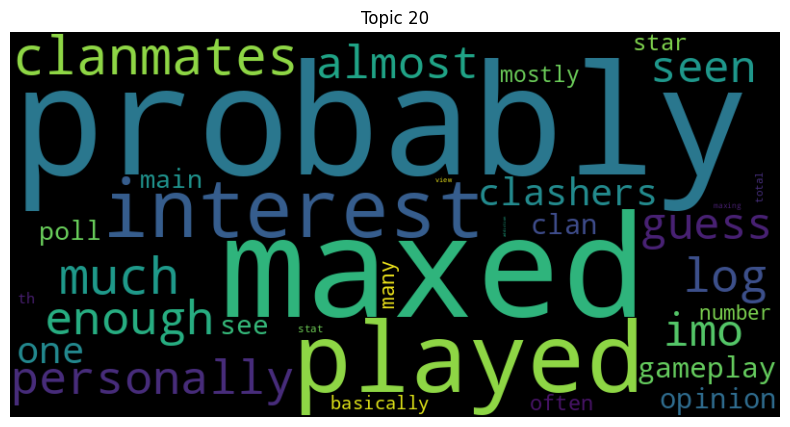

In [221]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_scores_per_new_topic_sorted = {k: word_scores_per_new_topic[k] for k in sorted(word_scores_per_new_topic.keys())}
# Step 2: Iterate through each topic
for topic_num, word_scores in word_scores_per_new_topic_sorted.items():
    
    # Step 3: Create a frequency dictionary from the word scores
    frequency_dict = {word: score for word, score in word_scores.items() if score > 0}  # Ignore negative scores
    
    # Step 4: Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(frequency_dict)
    
    # Step 5: Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_num}')
    plt.show()
